In [534]:
import backtrader as bt
import pandas as pd
import duckdb

etfs =  ['561300', '159726', '515100', '513500',
        '164824', '513330', '513100',
        '513030', '513520']
start_date = '2023-01-01'
end_date   = '2025-07-31'

con = duckdb.connect(database=':memory:', read_only=False) 
symbols_tuple = tuple(etfs)

path = '../dataset/data/etf_prices/**/*.parquet'

query = f"""
SELECT
    date,
    open,
    high,
    low,
    close,
    volume,
    turnover,
    symbol
FROM read_parquet('{path}')
WHERE symbol IN {symbols_tuple}
AND date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY symbol, date
"""

df_all = con.execute(query).df()
con.close()

# 类型转换
df_all['date'] = pd.to_datetime(df_all['date'])
numeric_cols = ['open', 'high', 'low', 'close', 'volume']
df_all[numeric_cols] = df_all[numeric_cols].astype(float)
df_all.tail(10)

,date,open,high,low,close,volume,turnover,symbol
5605,2025-07-18,0.863,0.869,0.862,0.868,785560.0,68041081.0,561300
5606,2025-07-21,0.868,0.875,0.868,0.875,584344.0,51008673.0,561300
5607,2025-07-22,0.874,0.883,0.870,0.883,365800.0,32098065.0,561300
5608,2025-07-23,0.883,0.890,0.880,0.883,887824.0,78415510.0,561300
5609,2025-07-24,0.885,0.888,0.881,0.887,291048.0,25767748.0,561300
5610,2025-07-25,0.886,0.888,0.881,0.885,423246.0,37446172.0,561300
5611,2025-07-28,0.885,0.889,0.881,0.887,243103.0,21528745.0,561300
5612,2025-07-29,0.887,0.890,0.882,0.890,370468.0,32827434.0,561300
5613,2025-07-30,0.890,0.897,0.885,0.890,303505.0,27054482.0,561300
5614,2025-07-31,0.888,0.888,0.869,0.871,1462362.0,127793264.0,561300


In [535]:
import backtrader as bt


class EqualWeightRebalance(bt.Strategy):
    params = dict(
        rebalance_days=20,   # 多少根 K 线再平衡一次
        lot_size=100
    )

    def __init__(self):
        self.counter = 0              # bar 计数器
        self.num_assets = len(self.datas)

    def next(self):
        self.counter += 1
        if self.counter % self.p.rebalance_days != 0:
            return

        total_value = self.broker.get_value()
        target_per_asset = total_value / self.num_assets

        for data in self.datas:
            pos = self.getposition(data)
            current_size = pos.size
            target_size = int(target_per_asset / data.close[0])

            # 向下取整到 100 的整数倍
            target_size = (target_size // self.p.lot_size) * self.p.lot_size

            diff = target_size - current_size
            if diff == 0:
                continue

            # 不允许做空
            if diff < 0:
                diff = max(diff, -current_size)

            # 确保仍是 100 的倍数（卖出时可能再限制）
            diff = (diff // self.p.lot_size) * self.p.lot_size
            if diff == 0:
                continue

            if diff > 0:
                self.buy(data=data, size=diff)
            else:
                self.sell(data=data, size=-diff)

    def notify_order(self, order):
        if order.status == order.Completed:
            print(
                f"{self.datetime.date(0)} | "
                f"{order.data._name} {'买入' if order.isbuy() else '卖出'} | "
                f"数量: {order.executed.size} | "
                f"价格: {order.executed.price:.2f}"
            )

In [536]:
import backtrader as bt


class ATRGridEventDriven(bt.Strategy):
    params = dict(
        atr_period=30,
        grid_nb=16,           # 网格总数（上下各5）
        reserve=0,         # 保留仓位比例
        risk_per_grid=1,   # 每格使用可动用资金的比例
        lot_size=100,           # 最小交易单位
        decay_factor=2,  # 指数衰减因子（越接近中心，步长越小）
        debug=False
    )

    def __init__(self):
        # --- 正确初始化所有状态为 dict ---
        self.atrs = {data: bt.indicators.ATR(data, period=self.p.atr_period) for data in self.datas}
        self.costs = {data: None for data in self.datas}
        self.grids = {data: [] for data in self.datas}
        self.executed_levels = {data: set() for data in self.datas}
        self.frozen_profit = {d: 0.0 for d in self.datas}

        self.num_assets = len(self.datas)
        self.initial_cash = self.broker.get_cash()



    def _avg_cost(self, data):
        pos = self.getposition(data)
        return pos.price if pos.size and abs(pos.size) > 1e-6 else None

    def _make_grid(self, data, center):
        """生成不对称网格：中间密集，两边疏松（指数衰减）"""
        atr = self.atrs[data][0]
        n = self.p.grid_nb // 2
        
        # 基础步长
        base_step = atr
        
        # 指数衰减因子（越接近中心，步长越小）
        decay_factor = self.p.decay_factor # 可调节参数，越大两边越疏松
        
        # 生成上网格（步长逐渐增大）
        upper = []
        current_price = center
        for i in range(n):
            step = base_step * (decay_factor ** (i * 0.5))  # 平方根衰减，更平滑
            current_price += step
            upper.append(current_price)
        
        # 生成下网格（步长逐渐增大）
        lower = []
        current_price = center
        for i in range(n):
            step = base_step * (decay_factor ** (i * 0.5))
            current_price -= step
            lower.append(current_price)
        
        # 组合网格并排序
        grid = lower[::-1] + [center] + upper
        return sorted(grid)

    def _get_crossed_levels(self, data, grid, prev_price, curr_price):
        """返回当前 K 线穿过的网格档位索引"""
        crossed = set()
        for i, price in enumerate(grid):
            if prev_price <= price < curr_price:
                crossed.add(i)  # 从下向上穿过
            elif curr_price < price <= prev_price:
                crossed.add(i)  # 从上向下穿过
        return crossed

    def next(self):
        capital_per_asset = self.initial_cash / self.num_assets

        for data in self.datas:
            self._next_for_data(data, capital_per_asset)

    def _next_for_data(self, data, capital_per_asset):
        close = data.close[0]
        prev_close = data.close[-1] if len(data.close) > 1 else close
        pos = self.getposition(data)
        pos_size = pos.size if abs(pos.size) > 1e-6 else 0

        # --- 1. 首次建仓或成本更新：重建网格
        new_cost = self._avg_cost(data)
        if pos_size == 0:
            # 无仓位：以当前价建网
            self.costs[data] = close
            self.grids[data] = self._make_grid(data, close)
            self.executed_levels[data] = set()  # 重置已执行记录

        grid = self.grids[data]
        if not grid:
            return

        ## 突破边界
        lowest_price, highest_price = grid[0], grid[-1]
        if close < lowest_price or close > highest_price:                      # 向下突破
            self.costs[data] = close
            self.grids[data]  = self._make_grid(data, close)
            self.executed_levels[data] = set()
            grid = self.grids[data]
            
        # --- 2. 检查价格穿过的网格
        crossed_levels = self._get_crossed_levels(data, grid, prev_close, close)
        new_executed = crossed_levels - self.executed_levels[data]  # 新触发的

        if not new_executed:
            return

        # --- 3. 计算每格下单量
        allocatable = capital_per_asset * (1 - self.p.reserve) 
        risk_per_leg = allocatable * self.p.risk_per_grid / (self.p.grid_nb // 2)
        unit_size = risk_per_leg / close
        unit_size = max(self.p.lot_size, int(unit_size / self.p.lot_size) * self.p.lot_size)

        if unit_size <= 0:
            return

        min_hold_value = capital_per_asset * self.p.reserve

        current_pos = self.getposition(data).size
        min_hold_size = int(min_hold_value / close)
        max_can_sell_total = max(0.0, current_pos - min_hold_size)
        total_sold_in_this_bar = 0.0  # ⬅️ 新增：累计已卖出量

        # --- 4. 对每个新触发的网格执行交易
        for idx in sorted(new_executed):
            price = grid[idx]

            if idx < len(grid) // 2:
                # 下方网格：买入加仓（抄底）
                self.buy(data=data, size=unit_size, exectype=bt.Order.Market)
                self.log(f"{data._name} 买入加仓 | 网格层级: {idx} | 数量: {unit_size} | 价格: {close:.2f}")

            elif idx > len(grid) // 2:
                # 计算剩余可卖
                remaining = max_can_sell_total - total_sold_in_this_bar
                if remaining < self.p.lot_size:
                    self.log(f"{data._name} | SELL | 可卖不足 | rem={remaining:.0f}", level="SKIP")
                    continue
        
                sell_size = min(unit_size, remaining)
                sell_size = (sell_size // self.p.lot_size) * self.p.lot_size
                if sell_size < self.p.lot_size:
                    continue
        
                self.sell(data=data, size=sell_size, exectype=bt.Order.Market)
                total_sold_in_this_bar += sell_size  # ✅ 累计
                self.log(f"{data._name} | SELL | 卖出 {sell_size} | 累计:{total_sold_in_this_bar}/{max_can_sell_total}", level="ORDER")

            # 标记为已执行
            self.executed_levels[data].add(idx)

    def log(self, txt, level="INFO"):
        if not self.p.debug:
            return
        """统一日志输出"""
        dt = self.datetime.date(0)
        time = self.datetime.time(0)
        print(f"{dt} {time} | {level:6} | {txt}")

    # def notify_order(self, order):
    #     if order.status in [order.Completed]:
    #         print(f"{self.datetime.date(0)} | "
    #               f"{order.data._name} 成交 | "
    #               f"方向: {'买入' if order.isbuy() else '卖出'} | "
    #               f"数量: {order.executed.size} | "
    #               f"价格: {order.executed.price:.2f}")

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log(f"【平仓】{trade.data._name} | "
                  f"盈亏: {trade.pnl:.2f}")

In [537]:
# ------------------------------------------------------------------
# 2. 构造 cerebro 并循环添加每个 ETF 的数据
# ------------------------------------------------------------------
cerebro = bt.Cerebro()

for symbol in etfs:
    # 取出当前标的
    df_sym = df_all[df_all['symbol'] == symbol].copy()

    # 确保按日期排序
    df_sym.sort_values('date', inplace=True)

    # 设置 datetime 为索引
    df_sym.set_index('date', inplace=True)

    # 删除多余的 symbol 列
    df_sym.drop(columns=['symbol'], inplace=True)

    # 缺失值前向填充（如有停牌）
    df_sym = df_sym.ffill()

    # 构建 backtrader 数据源
    data = bt.feeds.PandasData(
        dataname=df_sym,
        name=symbol,
        # 如果列名与默认一致，无需额外映射
    )
    cerebro.adddata(data)
# ------------------------------------------------------------------
# 3. 示例策略：每天收盘后打印所有标的价格
# ------------------------------------------------------------------

params = {'atr_period': 20, 'grid_nb': 20, 'decay_factor': 1.0}
# cerebro.addstrategy(EqualWeightRebalance)
cerebro.addstrategy(ATRGridEventDriven, **params)
cerebro.broker.set_shortcash(False)      # ❗禁止裸卖空
cerebro.broker.set_coc(True) 

cerebro.broker.setcommission(commission=0.0005)
cerebro.addanalyzer(bt.analyzers.PyFolio)
cerebro.addanalyzer(bt.analyzers.Transactions, _name='txns')

cerebro.broker.setcash(100000) 

# ------------------------------------------------------------------
# 4. 运行回测
# ------------------------------------------------------------------
results = cerebro.run()
strat = results[0]
txns = strat.analyzers.txns.get_analysis()
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.394%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2023-01-03
End date,2025-07-31
Total months,29
,Backtest
Annual return,8.394%
Cumulative returns,22.089%
Annual volatility,5.454%
Sharpe ratio,1.51
Calmar ratio,1.82
Stability,0.90
Max drawdown,-4.601%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.60,2023-08-01,2023-10-26,2024-02-19,145
1,4.23,2025-03-25,2025-04-07,2025-04-23,22
2,2.65,2024-07-15,2024-08-05,2024-09-24,52
3,1.52,2024-10-08,2024-11-22,2024-12-12,48
4,1.23,2023-05-18,2023-05-31,2023-06-09,17


/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.03%,-3.11%,2.98%


Top 10 long positions of all time,max
513520,15.84%


Top 10 short positions of all time,max


Top 10 positions of all time,max
513520,15.84%


/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/round_trips.py:139: FutureWarning: DataFrameGr

Summary stats,All trades,Long trades
Total number of round_trips,216.00,216.00
Percent profitable,0.88,0.88
Winning round_trips,189.00,189.00
Losing round_trips,27.00,27.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$15658.10,$15658.10
Gross profit,$18704.00,$18704.00
Gross loss,$-3045.90,$-3045.90
Profit factor,$6.14,$6.14
Avg. trade net profit,$72.49,$72.49
Avg. winning trade,$98.96,$98.96
Avg. losing trade,$-112.81,$-112.81
Ratio Avg. Win:Avg. Loss,$0.88,$0.88
Largest winning trade,$1060.60,$1060.60
Largest losing trade,$-383.50,$-383.50


Duration stats,All trades,Long trades
Avg duration,116 days 18:40:00.004629630,116 days 18:40:00.004629630
Median duration,81 days 00:00:00,81 days 00:00:00
Longest duration,791 days 00:00:00,791 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.10%,0.10%
Avg returns winning,0.14%,0.14%
Avg returns losing,-0.19%,-0.19%
Median returns all round_trips,0.05%,0.05%
Median returns winning,0.07%,0.07%
Median returns losing,-0.10%,-0.10%
Largest winning trade,1.41%,1.41%
Largest losing trade,-0.60%,-0.60%


Symbol stats,159726,164824,513030,513100,513330,513500,513520,515100,561300
Avg returns all round_trips,0.27%,0.16%,0.11%,0.02%,0.13%,0.06%,0.10%,0.09%,0.08%
Avg returns winning,0.27%,0.16%,0.14%,0.05%,0.31%,0.08%,0.18%,0.09%,0.27%
Avg returns losing,NaN,NaN,-0.13%,-0.17%,-0.32%,-0.08%,-0.36%,NaN,-0.14%
Median returns all round_trips,0.20%,0.12%,0.08%,0.02%,0.05%,0.03%,0.08%,0.09%,0.03%
Median returns winning,0.20%,0.12%,0.10%,0.03%,0.09%,0.04%,0.10%,0.09%,0.11%
Median returns losing,NaN,NaN,-0.07%,-0.10%,-0.32%,-0.07%,-0.40%,NaN,-0.11%
Largest winning trade,0.54%,0.61%,0.74%,0.17%,1.41%,0.32%,1.26%,0.20%,0.98%
Largest losing trade,0.03%,0.01%,-0.29%,-0.51%,-0.60%,-0.17%,-0.60%,0.01%,-0.34%


Profitability (PnL / PnL total) per name,
symbol,
159726,24.55%
513030,18.28%
164824,13.13%
513500,10.91%
513520,10.18%
513330,9.78%
561300,5.45%
513100,4.01%
515100,3.71%


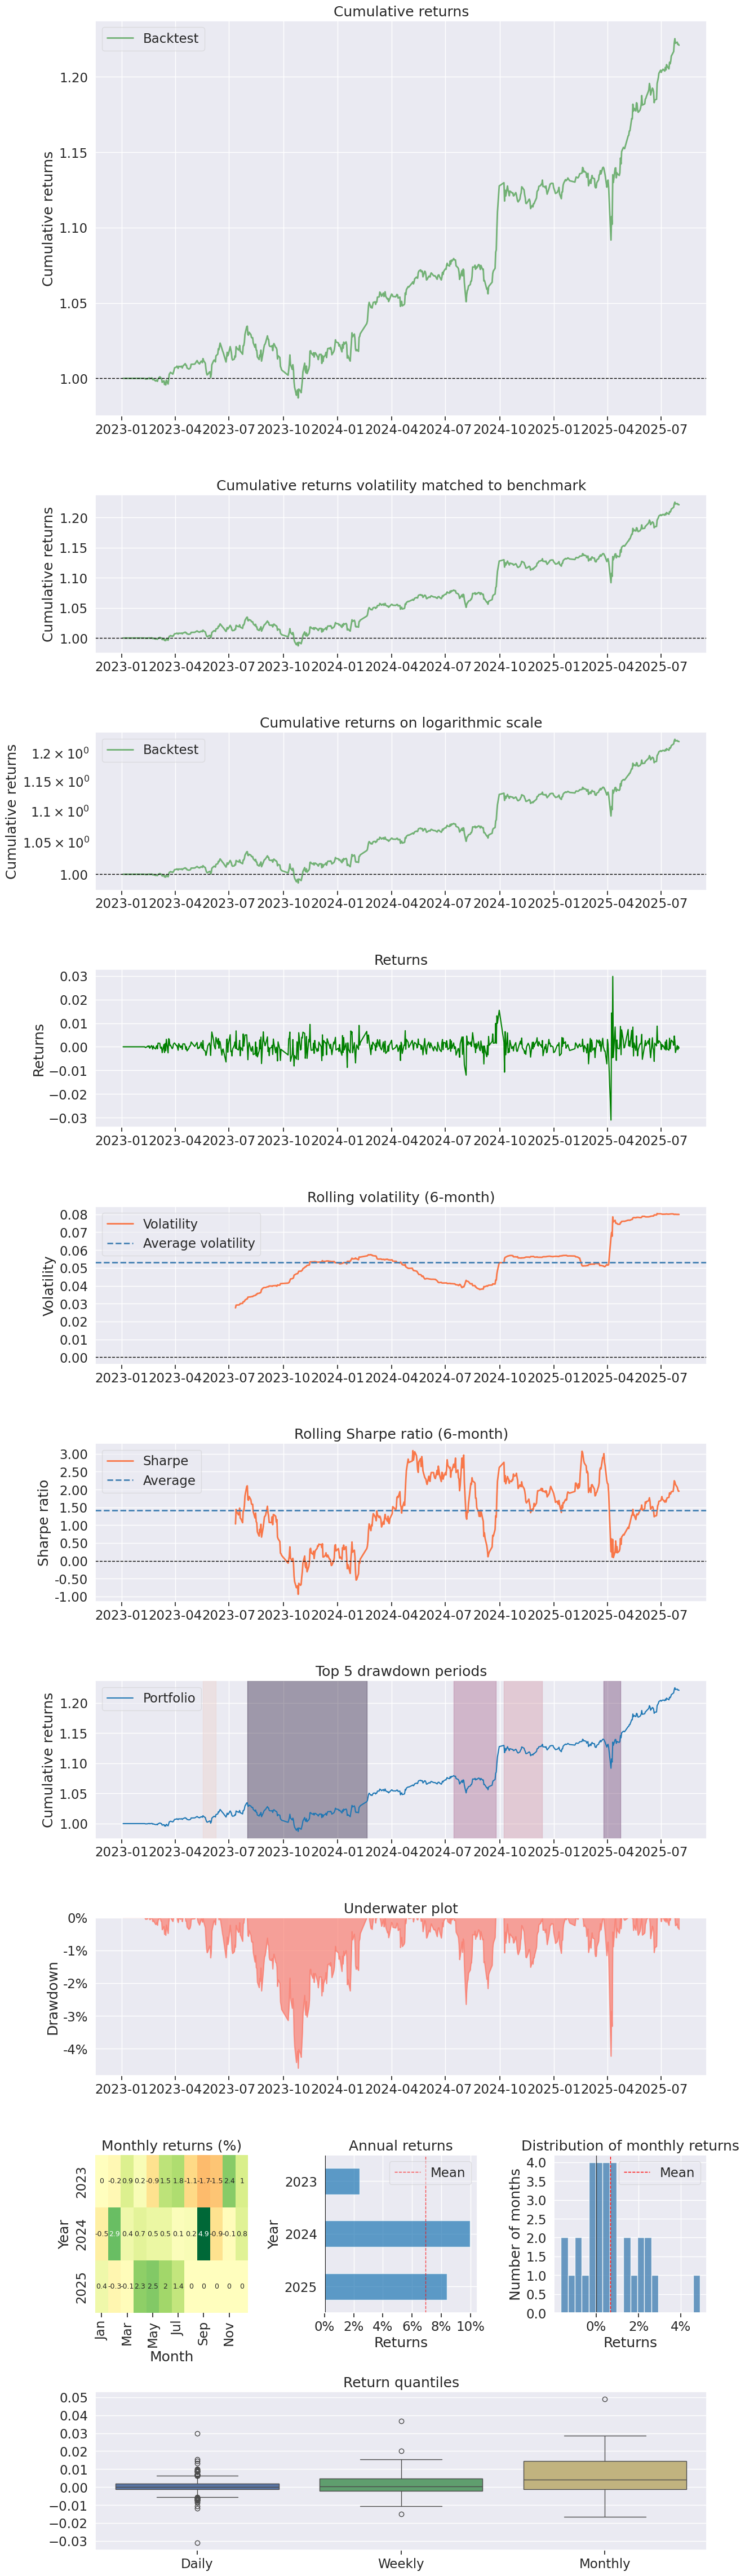

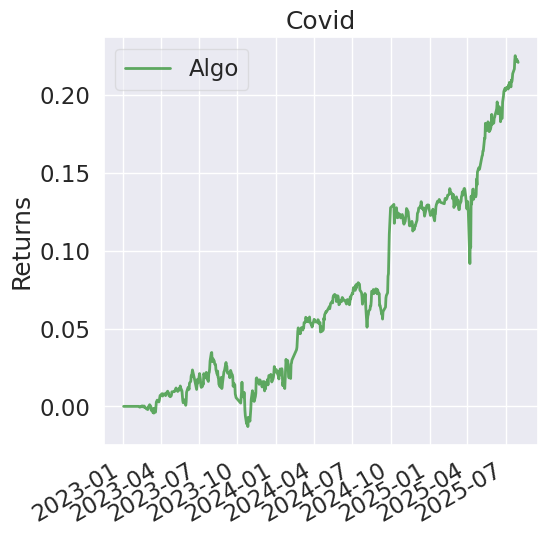

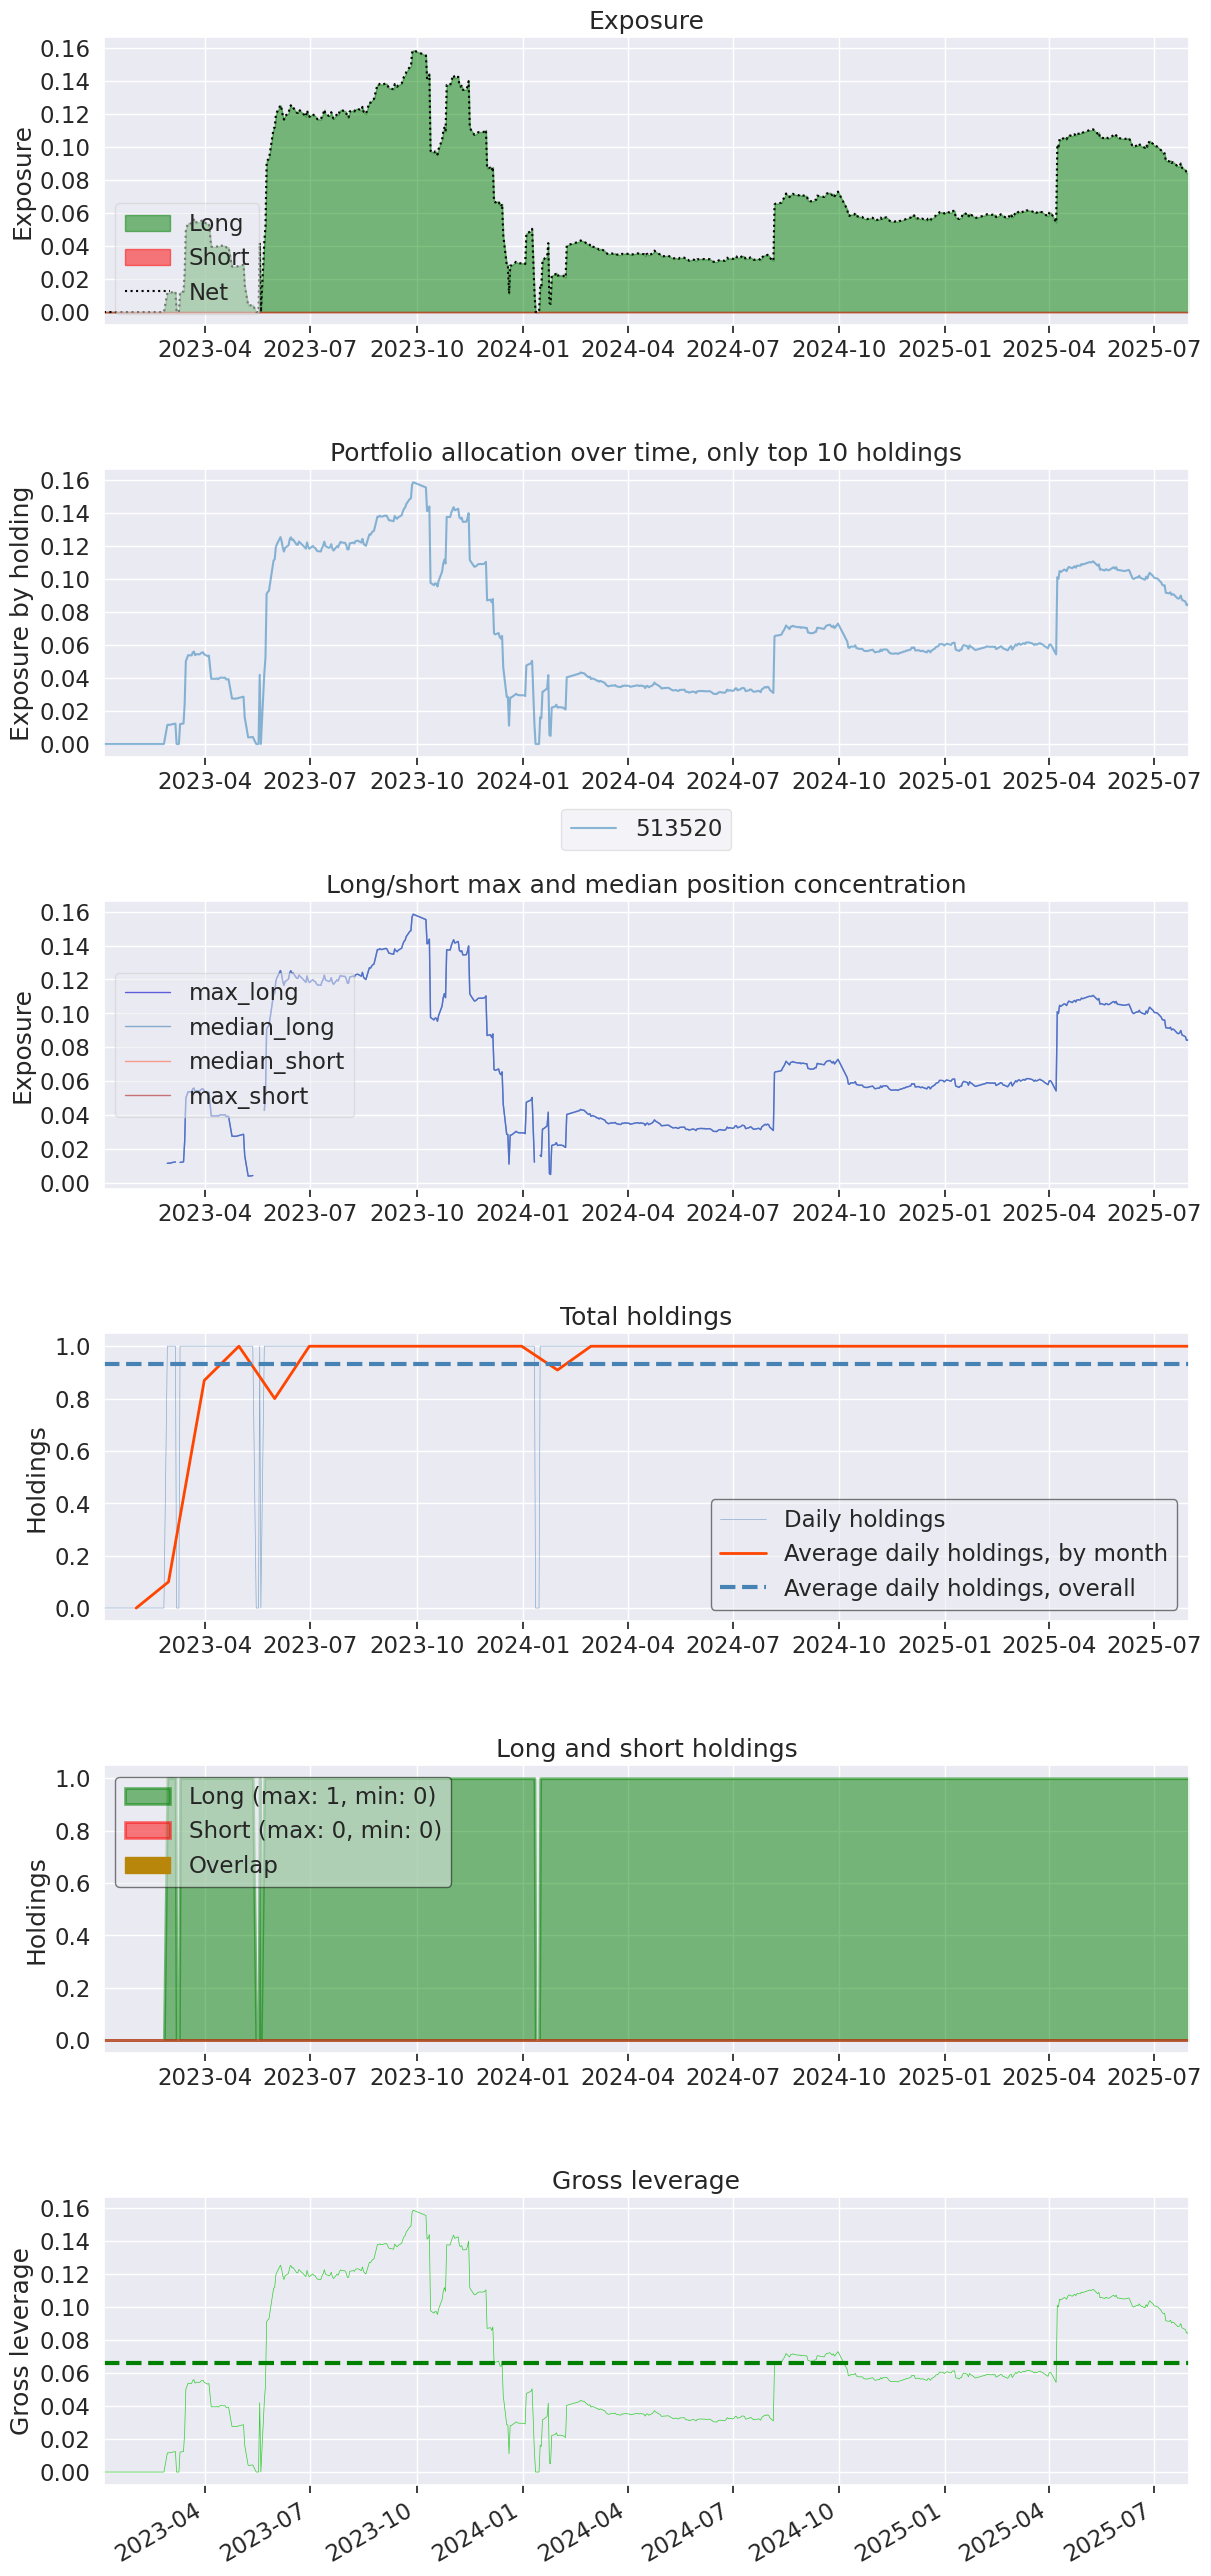

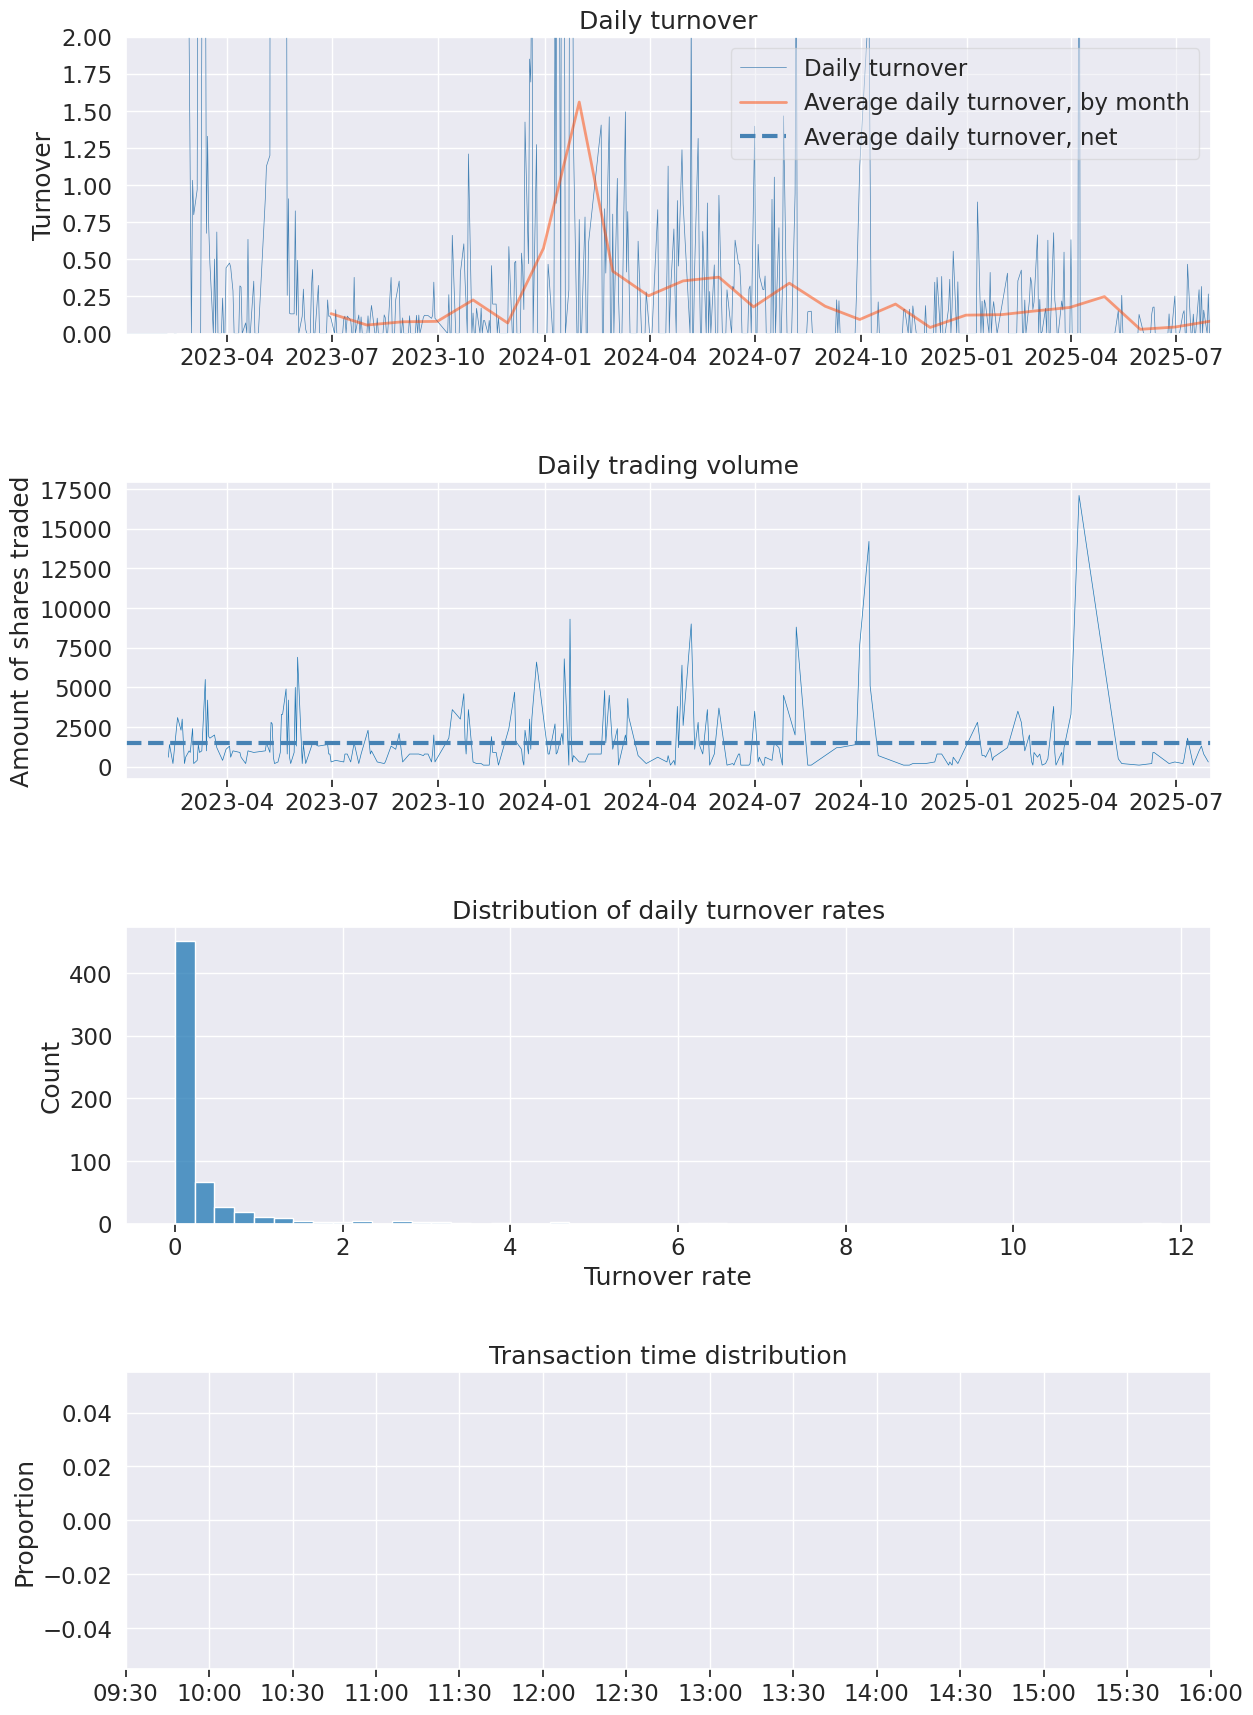

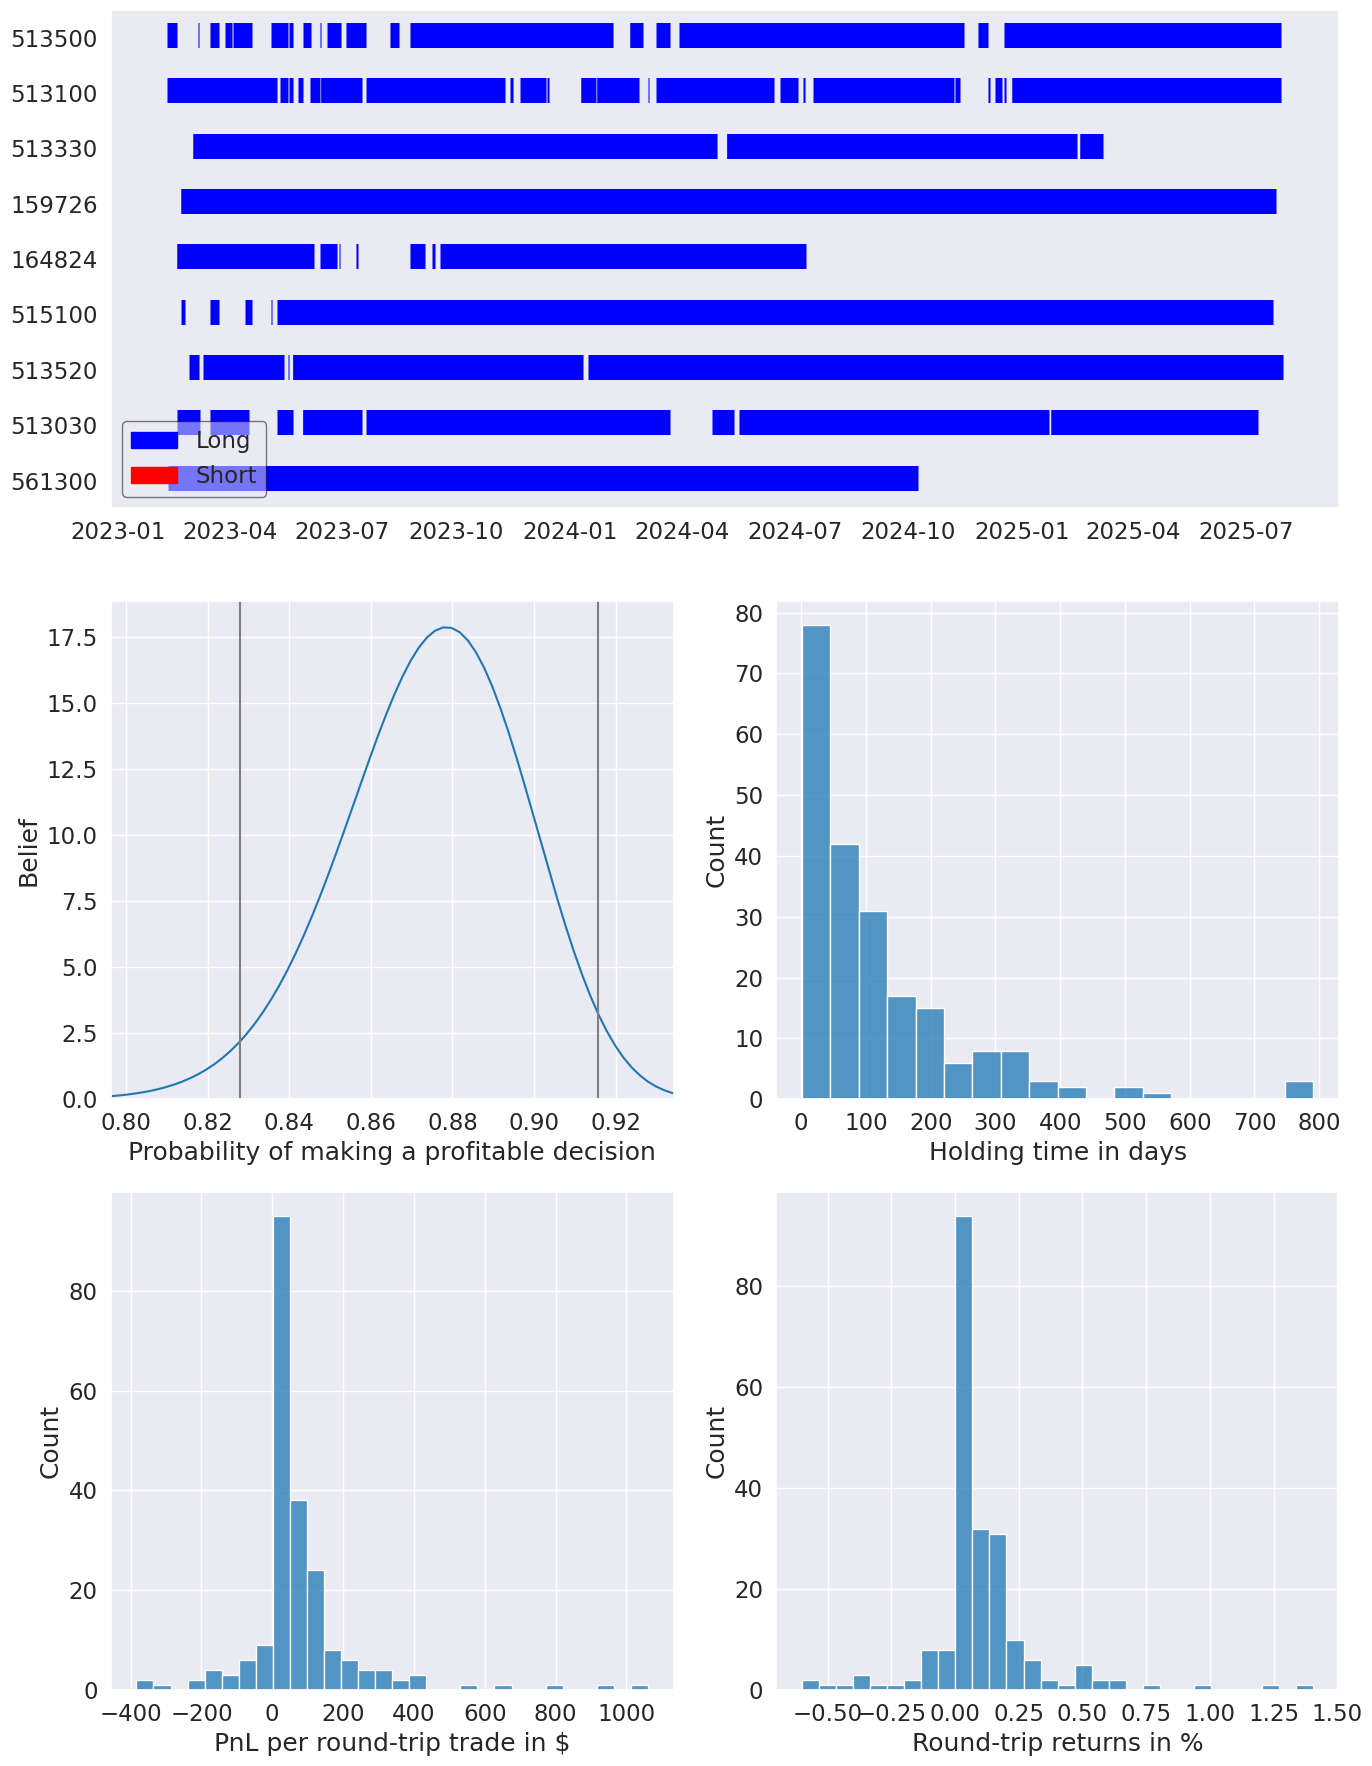

In [538]:
import pyfolio as pf

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    round_trips=True)

/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.507%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2022-07-01
End date,2025-07-31
Total months,35
,Backtest
Annual return,6.507%
Cumulative returns,20.606%
Annual volatility,4.869%
Sharpe ratio,1.32
Calmar ratio,1.54
Stability,0.96
Max drawdown,-4.235%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.23,2025-03-25,2025-04-07,2025-06-06,54
1,4.08,2023-08-01,2023-10-26,2024-01-09,116
2,3.55,2024-07-15,2024-08-05,2024-09-26,54
3,2.47,2023-05-19,2023-05-26,2023-06-13,18
4,1.66,2024-04-01,2024-04-19,2024-05-10,30


/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.03%,-2.98%,1.12%


Top 10 long positions of all time,max
513520,22.52%


Top 10 short positions of all time,max
513520,-0.74%


Top 10 positions of all time,max
513520,22.52%


/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()
/home/jovyan/data/.venv/lib/python3.12/site-packages/pyfolio/round_trips.py:139: FutureWarning: DataFrameGr

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,245.00,1.00,244.00
Percent profitable,0.82,0.00,0.82
Winning round_trips,200.00,0.00,200.00
Losing round_trips,45.00,1.00,44.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$18120.60,$-107.60,$18228.20
Gross profit,$24114.90,$0.00,$24114.90
Gross loss,$-5994.30,$-107.60,$-5886.70
Profit factor,$4.02,$0.00,$4.10
Avg. trade net profit,$73.96,$-107.60,$74.71
Avg. winning trade,$120.57,NaN,$120.57
Avg. losing trade,$-133.21,$-107.60,$-133.79
Ratio Avg. Win:Avg. Loss,$0.91,NaN,$0.90
Largest winning trade,$1622.10,$-107.60,$1622.10
Largest losing trade,$-906.20,$-107.60,$-906.20


Duration stats,All trades,Short trades,Long trades
Avg duration,128 days 02:26:56.330612244,108 days,128 days 04:25:34.430327868
Median duration,92 days 00:00:00,108 days,92 days 00:00:00
Longest duration,789 days 00:00:00,108 days,789 days 00:00:00
Shortest duration,6 days 00:00:01,108 days,6 days 00:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.09%,-0.12%,0.09%
Avg returns winning,0.15%,NaN,0.15%
Avg returns losing,-0.17%,-0.12%,-0.17%
Median returns all round_trips,0.07%,-0.12%,0.07%
Median returns winning,0.09%,NaN,0.09%
Median returns losing,-0.11%,-0.12%,-0.11%
Largest winning trade,2.03%,-0.12%,2.03%
Largest losing trade,-1.15%,-0.12%,-1.15%


Symbol stats,159726,164824,513030,513100,513330,513500,513520,515100,561300
Avg returns all round_trips,0.16%,0.04%,0.12%,0.05%,0.21%,0.01%,0.09%,0.11%,0.08%
Avg returns winning,0.19%,0.08%,0.16%,0.11%,0.40%,0.07%,0.25%,0.11%,0.09%
Avg returns losing,-0.12%,-0.25%,-0.11%,-0.21%,-0.19%,-0.21%,-0.15%,NaN,-0.02%
Median returns all round_trips,0.16%,0.03%,0.11%,0.08%,0.18%,0.04%,0.03%,0.10%,0.04%
Median returns winning,0.18%,0.03%,0.13%,0.11%,0.25%,0.06%,0.16%,0.10%,0.05%
Median returns losing,-0.15%,-0.06%,-0.10%,-0.09%,-0.20%,-0.04%,-0.12%,NaN,-0.02%
Largest winning trade,0.66%,0.45%,0.82%,0.28%,2.03%,0.21%,0.80%,0.38%,0.36%
Largest losing trade,-0.19%,-0.65%,-0.20%,-0.70%,-0.43%,-1.15%,-0.49%,0.01%,-0.04%


Profitability (PnL / PnL total) per name,
symbol,
159726,21.11%
513030,19.69%
513330,18.71%
513520,12.06%
513100,7.87%
515100,6.72%
561300,5.65%
164824,5.24%
513500,2.93%


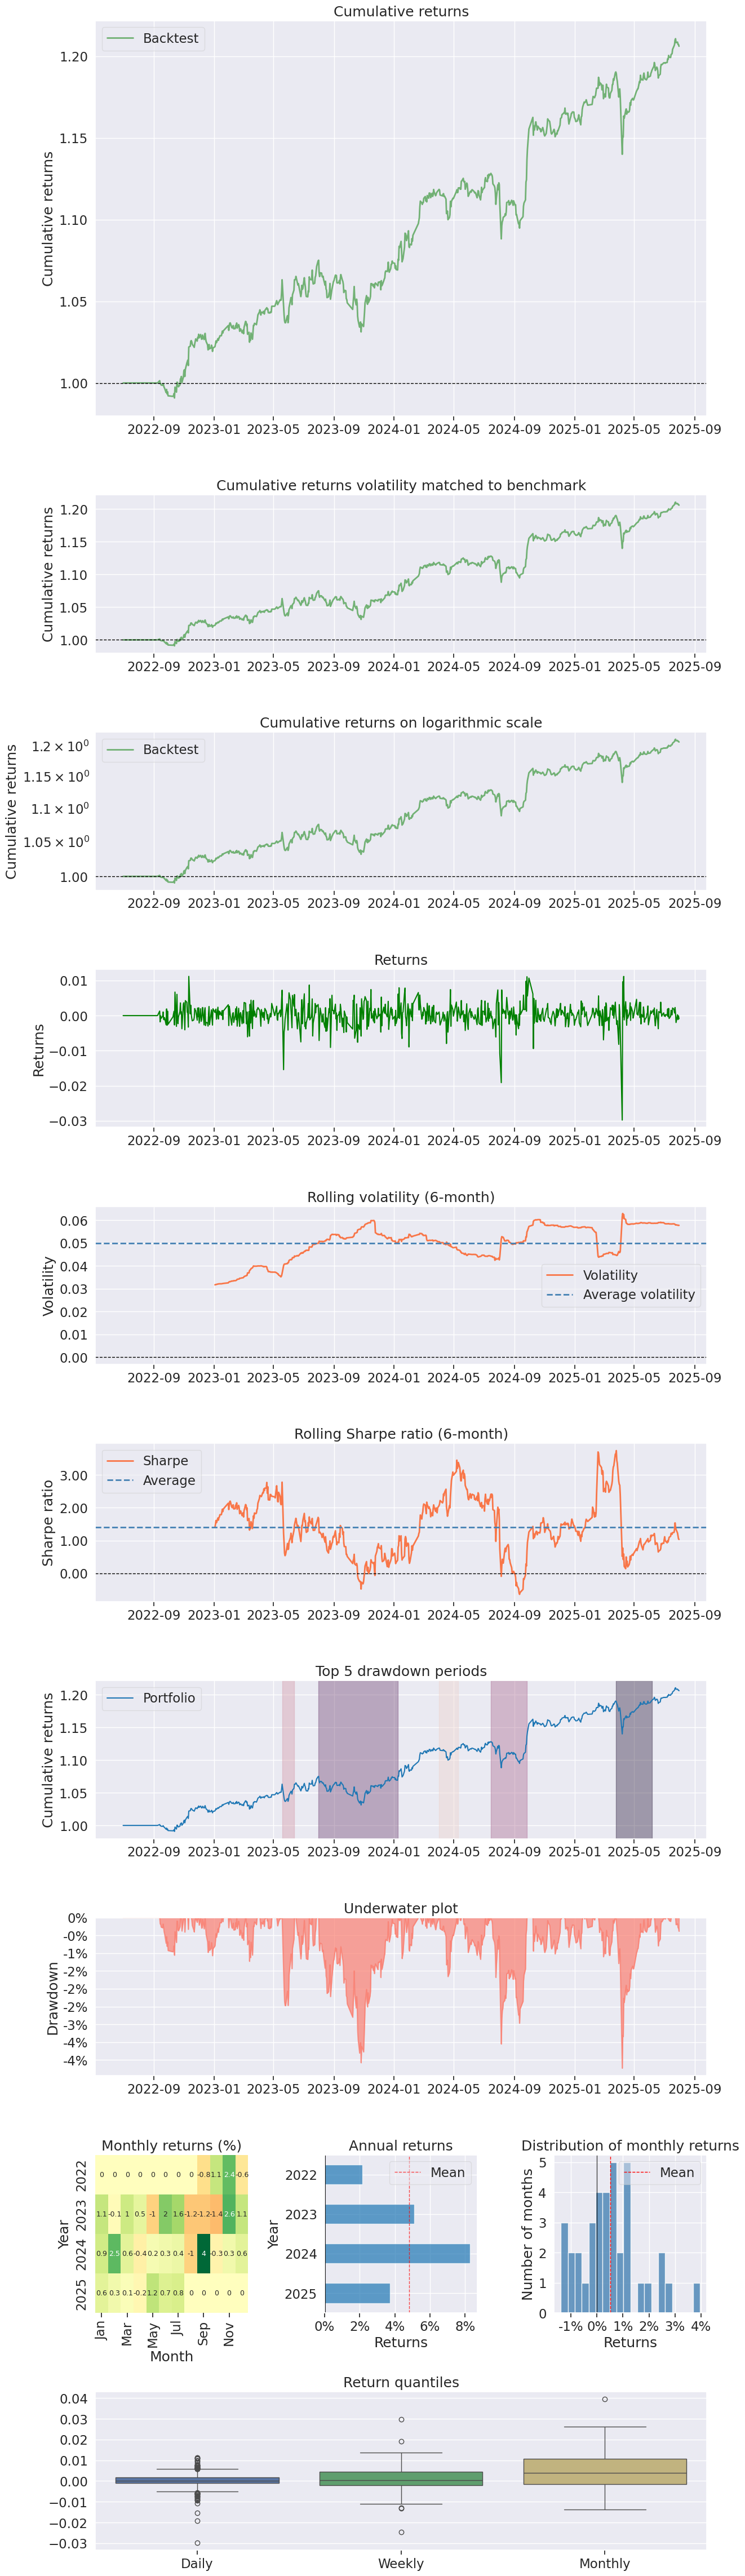

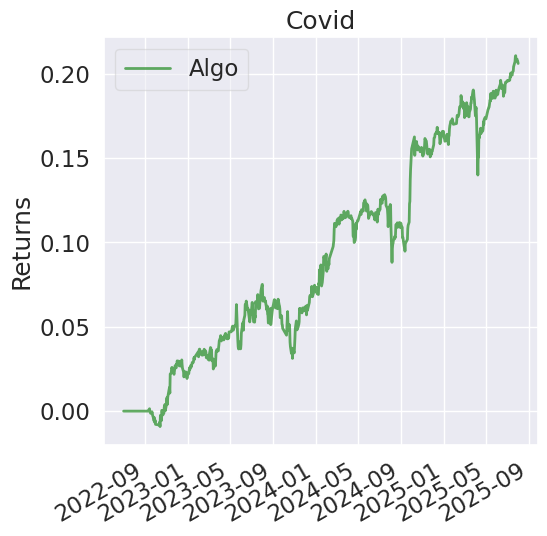

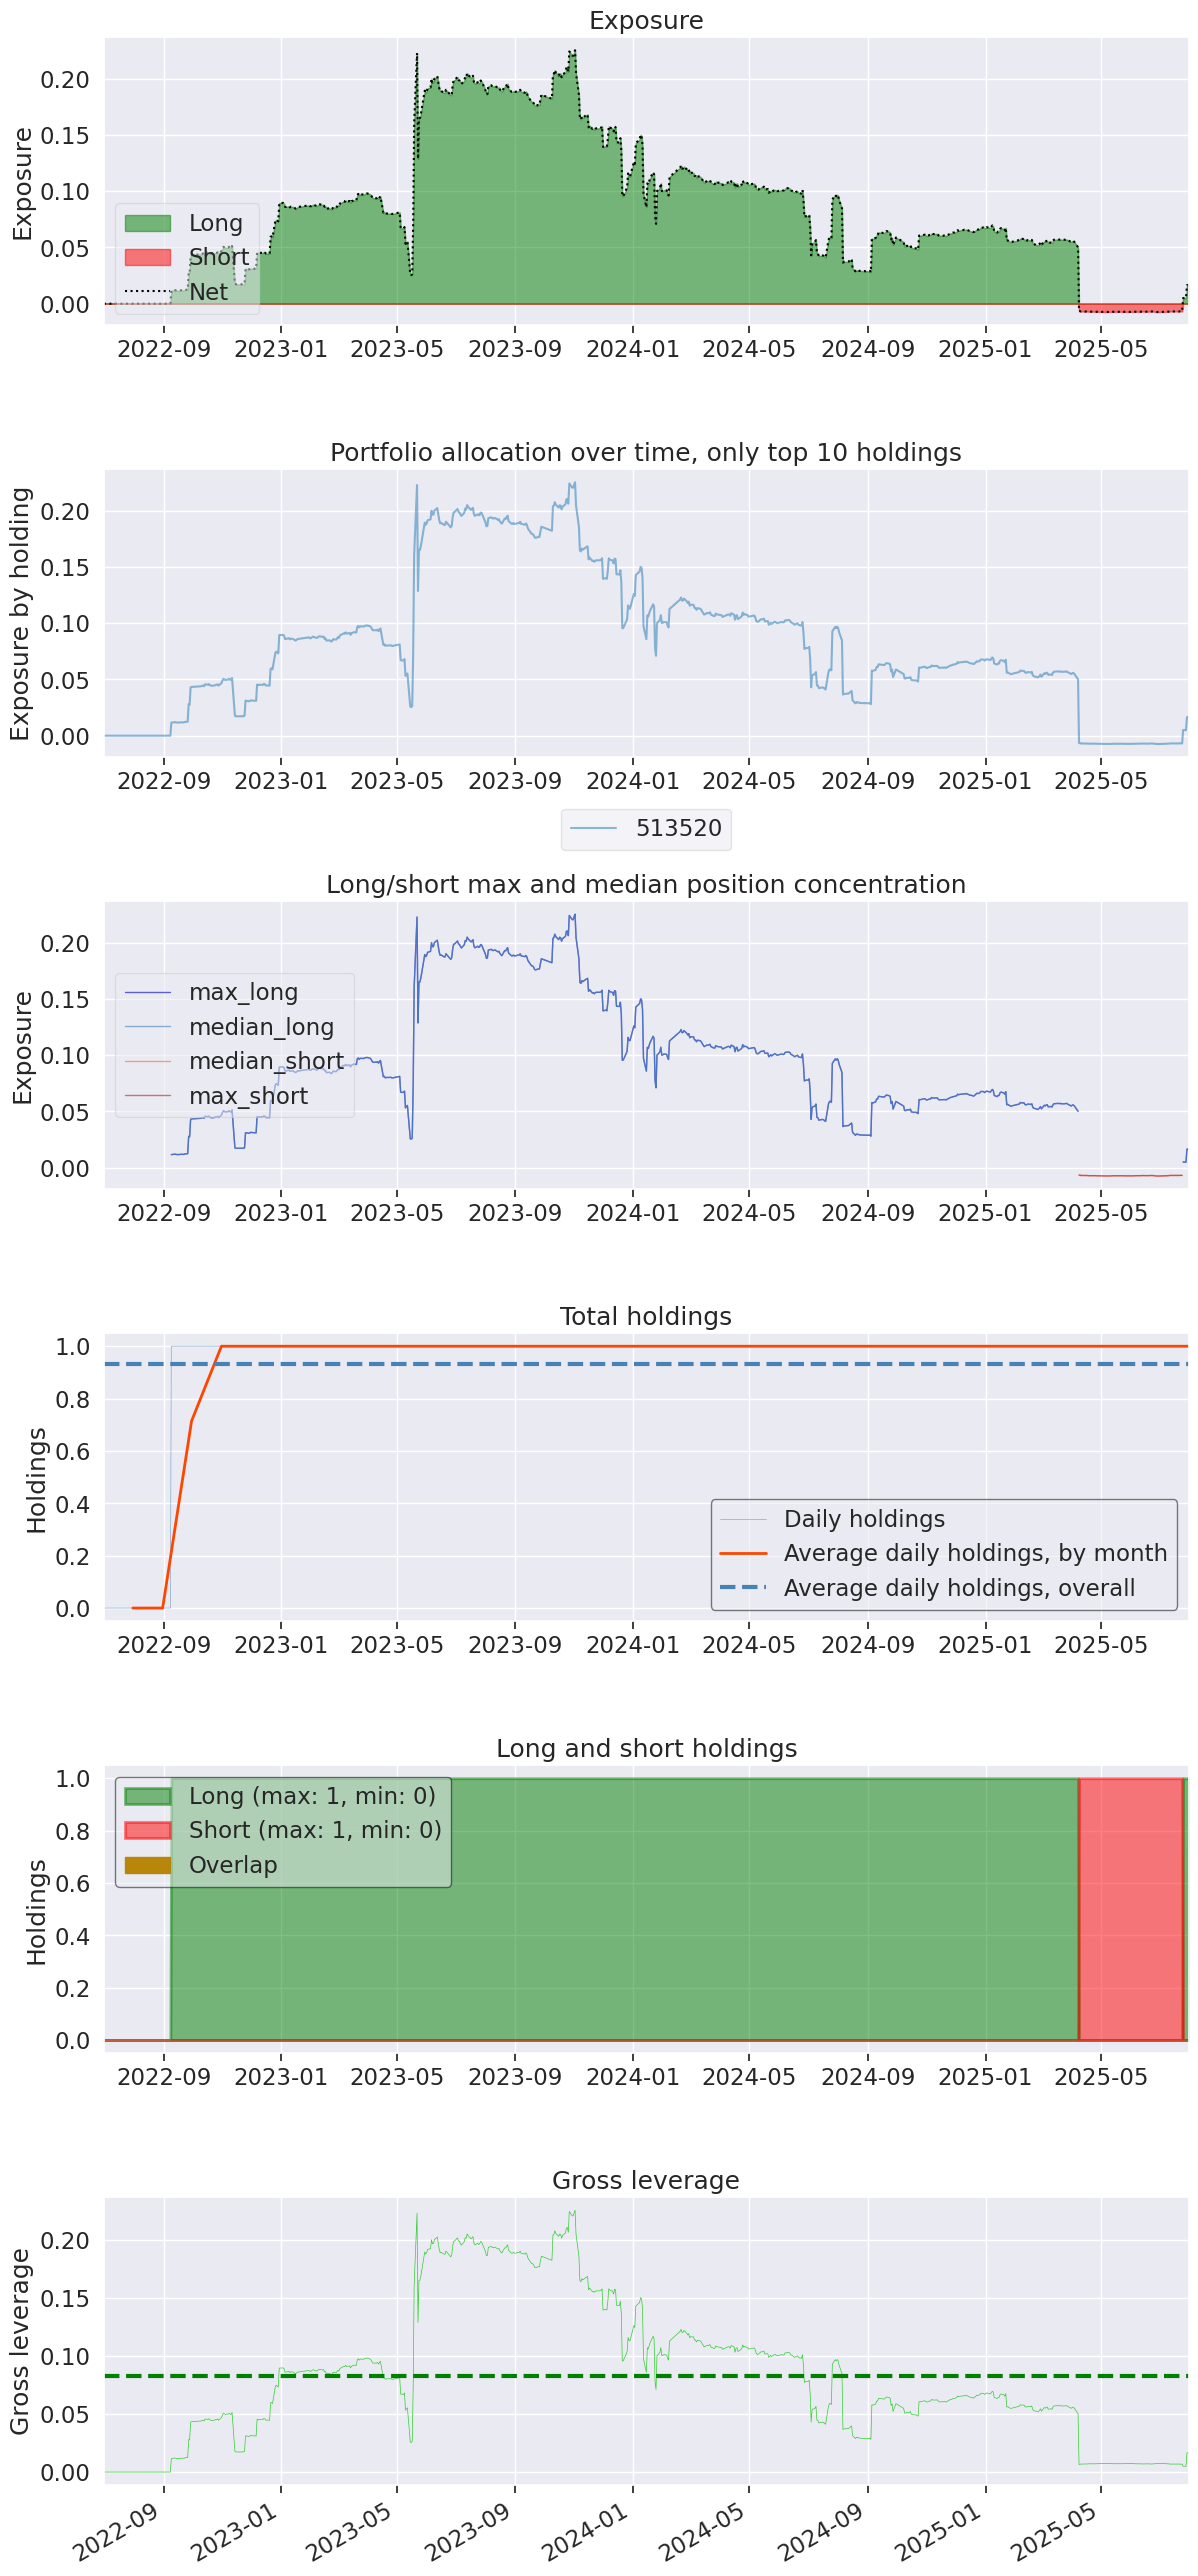

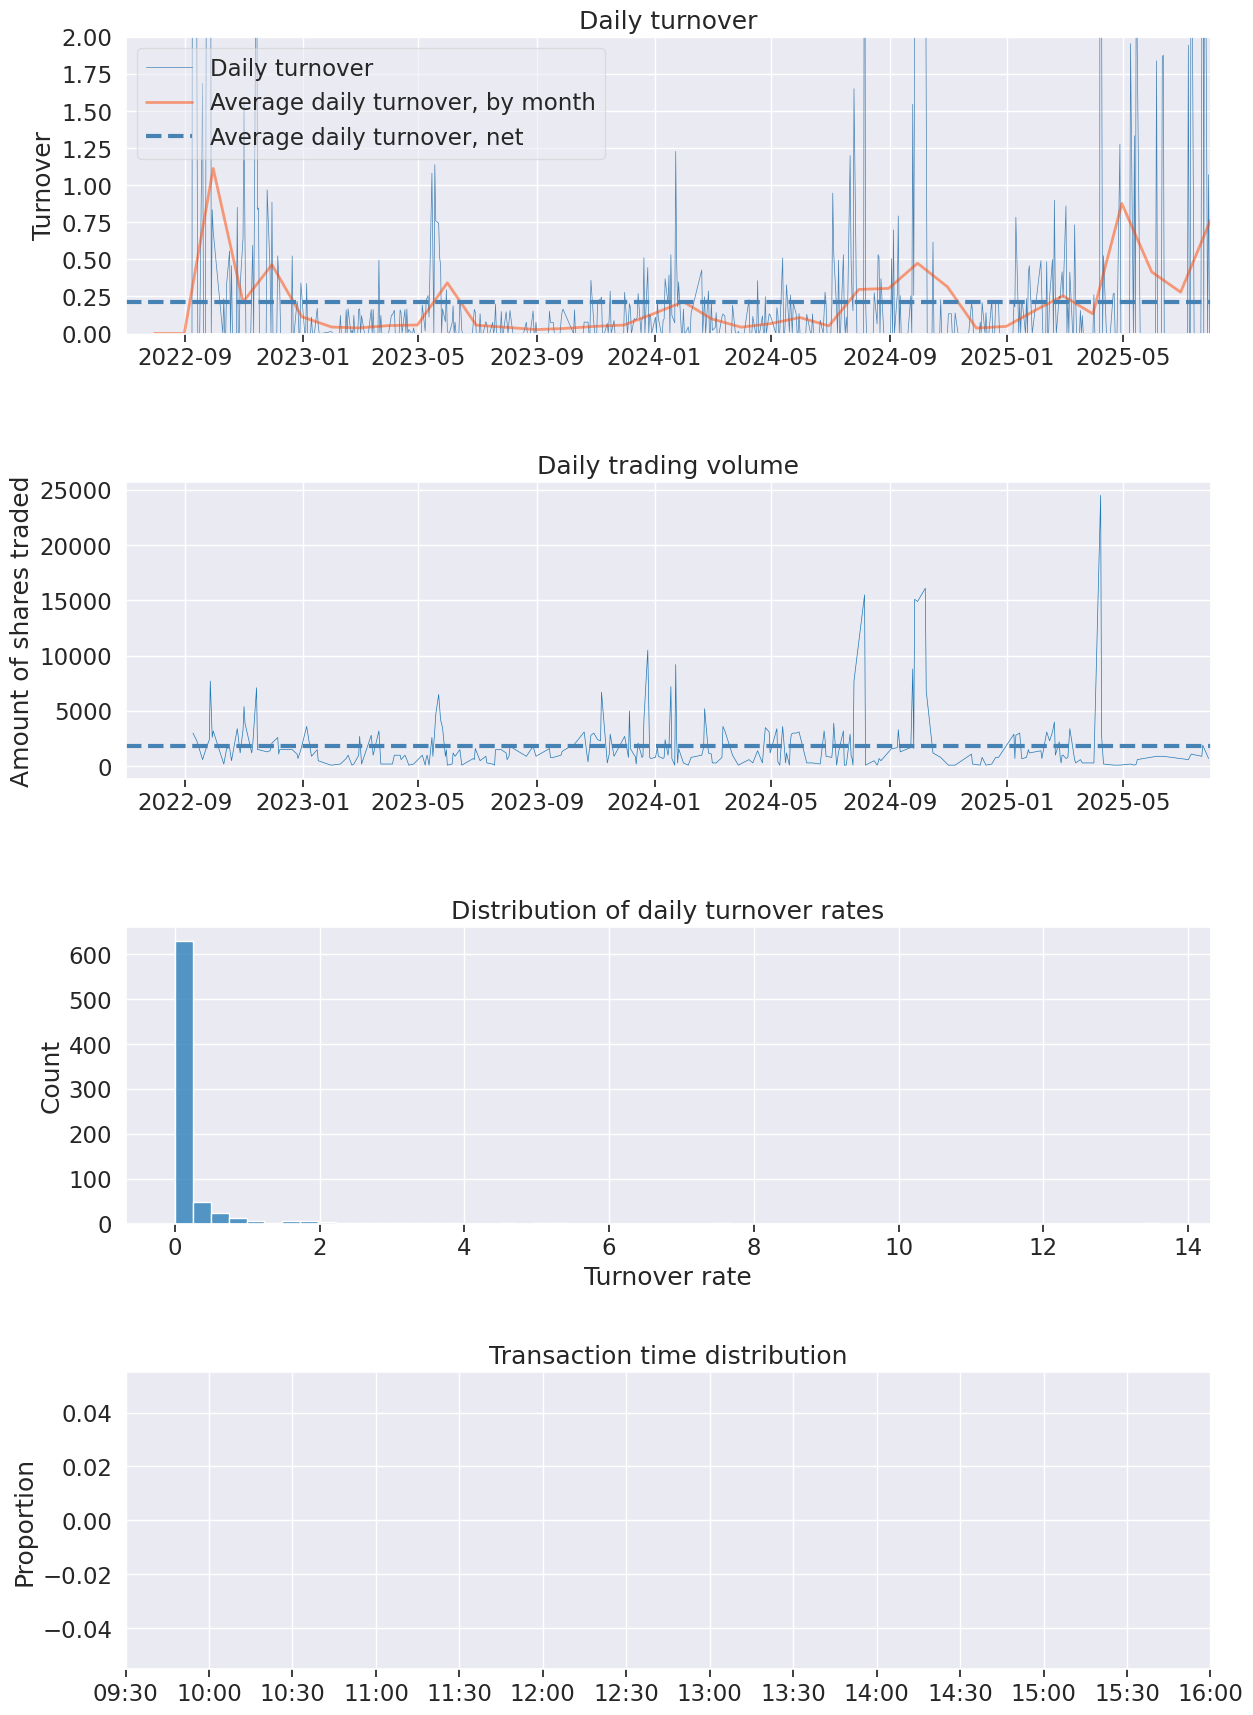

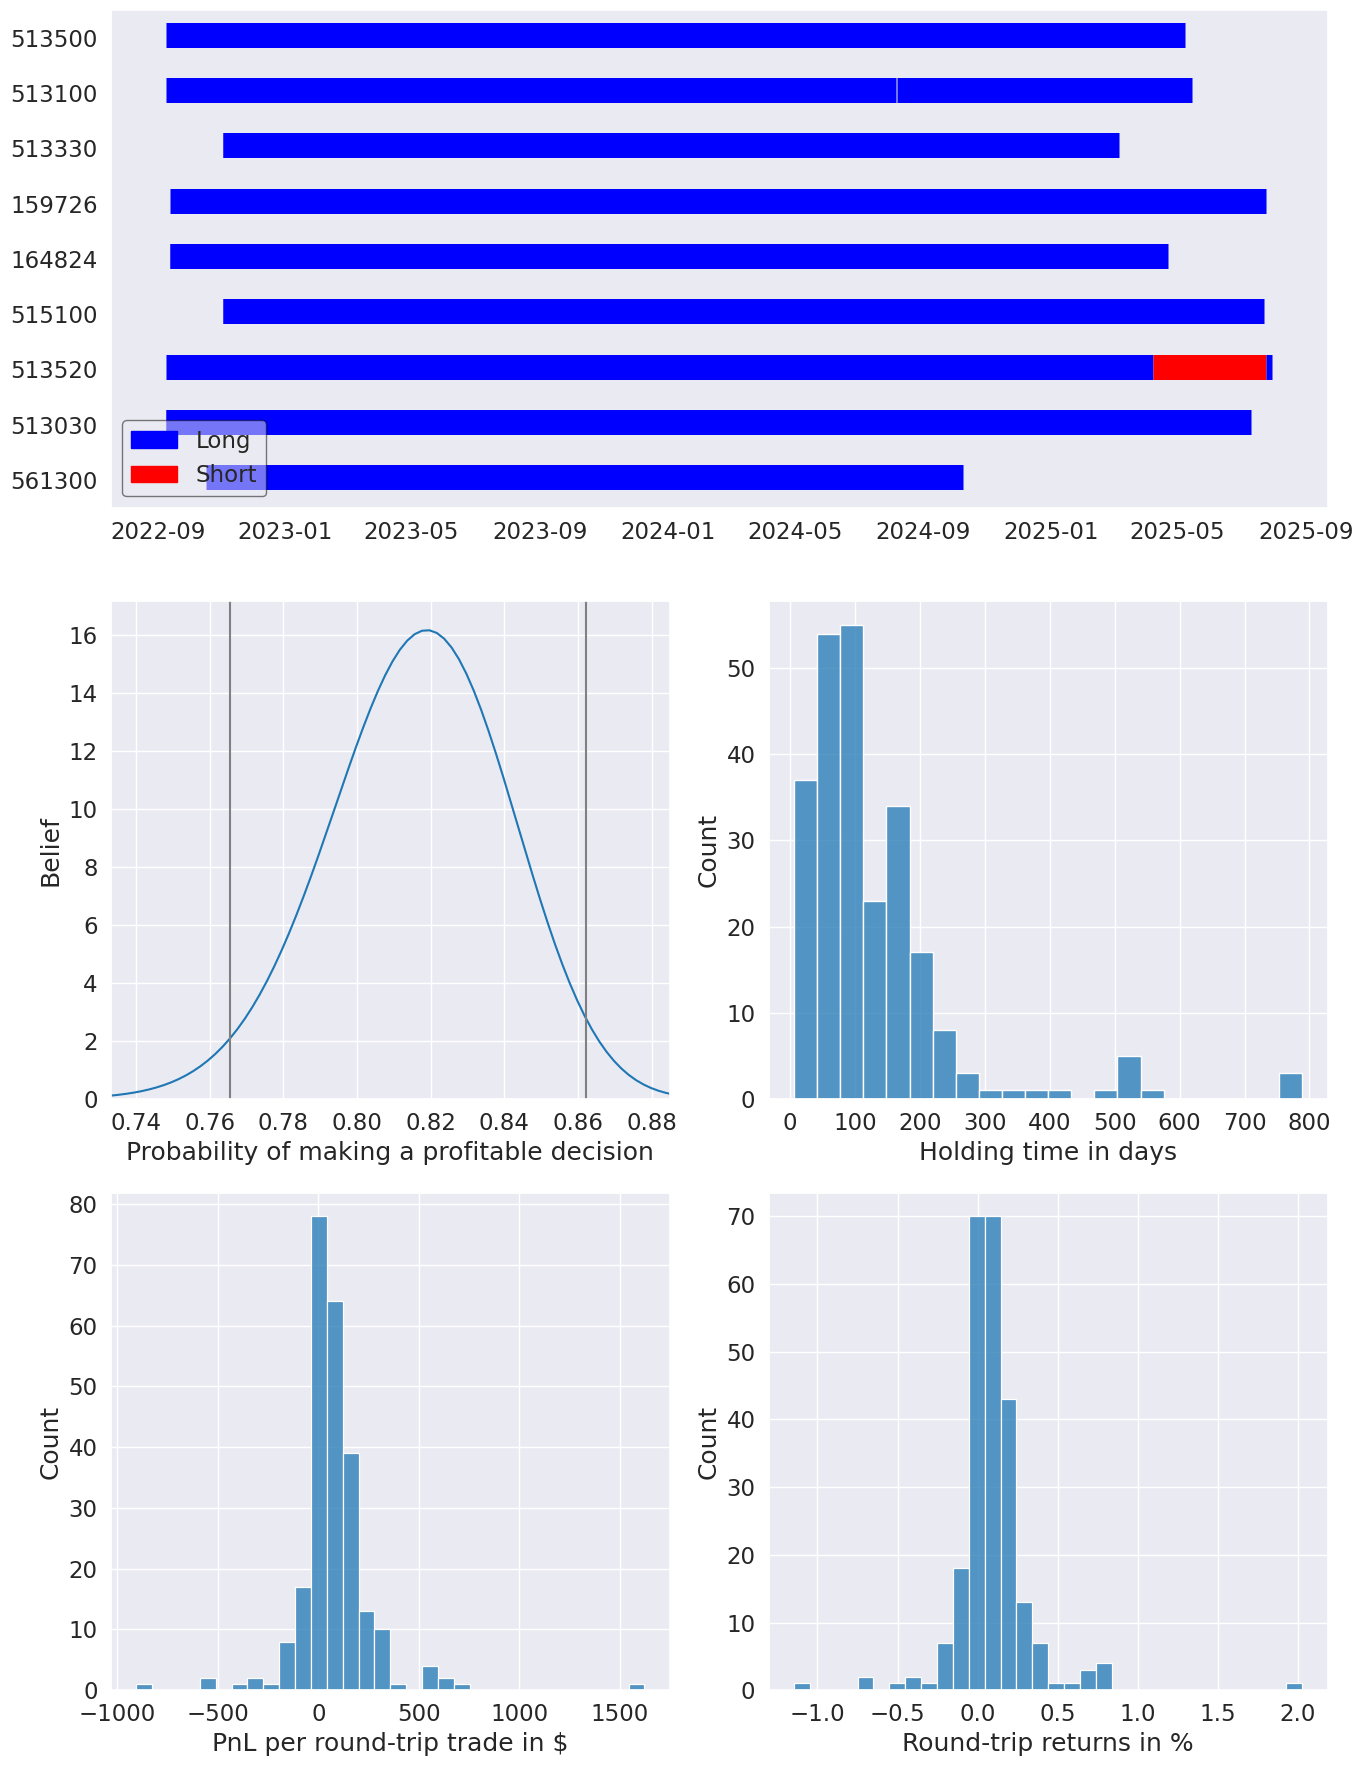

In [451]:
import pyfolio as pf

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    round_trips=True)

In [533]:
import optuna


def objective(trial):
    params = dict(
        atr_period   = trial.suggest_int('atr_period',   10,  120, step=2),   # 也可固定30
        grid_nb      = trial.suggest_int('grid_nb',       8,   20, step=4),
        decay_factor = trial.suggest_float('decay_factor', 1.0, 2.0, step=0.2),
    )

    
    cerebro = bt.Cerebro()
    for symbol in etfs:
        # 取出当前标的
        df_sym = df_all[df_all['symbol'] == symbol].copy()
    
        # 确保按日期排序
        df_sym.sort_values('date', inplace=True)
    
        # 设置 datetime 为索引
        df_sym.set_index('date', inplace=True)
    
        # 删除多余的 symbol 列
        df_sym.drop(columns=['symbol'], inplace=True)
    
        # 缺失值前向填充（如有停牌）
        df_sym = df_sym.ffill()
    
        # 构建 backtrader 数据源
        data = bt.feeds.PandasData(
            dataname=df_sym,
            name=symbol,
            # 如果列名与默认一致，无需额外映射
        )
        cerebro.adddata(data)
        
    cerebro.broker.setcash(100_000)
    cerebro.broker.setcommission(commission=0.0003)

    # 把参数传给策略
    cerebro.addstrategy(ATRGridEventDriven, **params)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    results = cerebro.run()
    sharpe = results[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)
    return sharpe if sharpe else 0.0   # Optuna 只接受最大化

# ------------------- 运行优化 -------------------
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    print("最佳参数：", study.best_params)
    print("最佳夏普：", study.best_value)

[I 2025-08-18 20:58:21,454] A new study created in memory with name: no-name-cc8634ad-f474-4b1c-b5b8-ccacacbb69f9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-18 20:58:22,047] Trial 0 finished with value: 1.8821951993705752 and parameters: {'atr_period': 38, 'grid_nb': 16, 'decay_factor': 1.2}. Best is trial 0 with value: 1.8821951993705752.
[I 2025-08-18 20:58:22,290] Trial 1 finished with value: 0.6052398123223122 and parameters: {'atr_period': 72, 'grid_nb': 12, 'decay_factor': 1.2}. Best is trial 0 with value: 1.8821951993705752.
[I 2025-08-18 20:58:22,527] Trial 2 finished with value: 1.01161458987831 and parameters: {'atr_period': 68, 'grid_nb': 8, 'decay_factor': 1.6}. Best is trial 0 with value: 1.8821951993705752.
[I 2025-08-18 20:58:22,763] Trial 3 finished with value: 1.0079840785135321 and parameters: {'atr_period': 30, 'grid_nb': 16, 'decay_factor': 2.0}. Best is trial 0 with value: 1.8821951993705752.
[I 2025-08-18 20:58:23,010] Trial 4 finished with value: 1.0556615167800298 and parameters: {'atr_period': 12, 'grid_nb': 20, 'decay_factor': 1.4}. Best is trial 0 with value: 1.8821951993705752.
[I 2025-08-18 20:58:23,